In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, RFE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample

### `Load data numerical, categorical and target`

In [ ]:
numericals = pd.read_csv('data/numerical.csv')
categoricals = pd.read_csv('data/categorical.csv')
targets = pd.read_csv('data/target.csv')

print(f"Numericals shape: {numericals.shape}")
print(f"Categoricals shape: {categoricals.shape}")
print(f"Targets shape: {targets.shape}")

In [ ]:
numericals_with_nan = [col for col in numericals.columns if numericals[col].isna().sum() > 0]
categoricals_with_nan = [col for col in categoricals.columns if categoricals[col].isna().sum() > 0]
targets_with_nan = [col for col in targets.columns if targets[col].isna().sum() > 0]

print(f"There are '{len(numericals_with_nan)}' NaN columns in Numericals.")
print(f"There are '{len(categoricals_with_nan)}' NaN columns in Categoricals.")
print(f"There are '{len(targets_with_nan)}' NaN columns in Targets.")

In [ ]:
categoricals.dropna(subset=categoricals_with_nan, inplace=True)
categoricals[categoricals_with_nan].value_counts(dropna=False)

In [ ]:
important_columns = ['WEALTH1', 'WEALTH2', 'VETERANS', 'SOLIH']

### `Numericals - Variance Threshold`

In [ ]:
min_max_scaler = MinMaxScaler()
numericals_scaled = min_max_scaler.fit_transform(numericals)

In [ ]:
selector = VarianceThreshold(0.09)
selected_numericals = selector.fit_transform(numericals_scaled)

columns_to_drop = [col_tuple[0] for col_tuple in zip(numericals.columns, selector.get_support()) if col_tuple[1] == False]

print(f"There are '{len(columns_to_drop)}' columns to drop.")

In [ ]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_variance = numericals.drop(columns_to_drop, axis=1)
numericals_variance.shape

In [ ]:
# Save results to csv

numericals_variance.to_csv('numericals_cleaned/numericals_variance.csv')

In [ ]:
def display_heatmap(dataframe):
    corr=dataframe.corr()

    mask=np.triu(np.ones_like(corr, dtype=bool))     # generate a mask for the upper triangle

    f, ax=plt.subplots(figsize=(11, 9))                 # set up the matplotlib figure

    cmap=sns.diverging_palette(220, 10, as_cmap=True)   # generate a custom diverging colormap

    sns.heatmap(corr, mask=mask, cmap=cmap,             # draw the heatmap with the mask and correct aspect ratio
                vmax=.3, center=0, square=True,
                linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
display_heatmap(pd.concat([targets[['TARGET_B']], numericals_variance], axis=1))

In [ ]:
numericals_variance_manual_drop = numericals_variance.drop(['POP90C3', 'HC6', 'HC7', 'CLUSTER2'], axis=1)
numericals_variance_manual_drop.shape

In [ ]:
# Save results to csv

numericals_variance_manual_drop.to_csv('numericals_cleaned/numericals_variance_manual_drop.csv')

In [ ]:
display_heatmap(pd.concat([targets[['TARGET_B']], numericals_variance_manual_drop], axis=1))

### `Numericals - Chi2`

In [ ]:
selector = SelectKBest(chi2, k=10)
selector.fit(numericals_scaled, targets[['TARGET_B']])
mask = selector.get_support()
columns_to_drop = numericals.columns[~mask]

print(f"There are '{len(columns_to_drop)}' columns to drop.")

In [ ]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_chi2 = numericals.drop(columns_to_drop, axis=1)
numericals_chi2.shape

In [ ]:
# Save results to csv

numericals_chi2.to_csv('numericals_cleaned/numericals_chi2.csv')

In [ ]:
display_heatmap(pd.concat([targets[['TARGET_B']], numericals_chi2], axis=1))

### `Numericals - RFE`

In [ ]:
model = LinearRegression()

# Create an instance of the RFE class
rfe = RFE(model, n_features_to_select=25, verbose=False)

# Fit the RFE to the DataFrame
rfe.fit(numericals_scaled, targets[['TARGET_B']])

# Get the boolean mask of the selected columns
mask = rfe.support_

# Use the mask to obtain the names of the selected columns
columns_to_drop = numericals.columns[~mask]

print(f"There are '{len(columns_to_drop)}' columns to drop.")

In [ ]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_rfe = numericals.drop(columns_to_drop, axis=1)
numericals_rfe.shape

In [ ]:
# Save results to csv

numericals_rfe.to_csv('numericals_cleaned/numericals_rfe.csv')

In [ ]:
display_heatmap(pd.concat([targets[['TARGET_B']], numericals_rfe], axis=1))

In [ ]:
numericals_rfe_manual_drop = numericals_rfe.drop(['POP90C1', 'DW1', 'MC2'], axis=1)
numericals_rfe_manual_drop.shape

In [ ]:
# Save results to csv

numericals_rfe_manual_drop.to_csv('numericals_cleaned/numericals_rfe_manual_drop.csv')

In [ ]:
display_heatmap(pd.concat([targets[['TARGET_B']], numericals_rfe_manual_drop], axis=1))

### `Numericals - OLS`

In [ ]:
df = sm.add_constant(numericals_scaled)

# Fit the OLS model
model = sm.OLS(targets[['TARGET_B']], df)
results = model.fit()

# Get the p-values of the features
pvalues = results.pvalues

# Select the features with a p-value more than 0.05
columns_to_drop = [col_tuple[0] for col_tuple in zip(numericals.columns, pvalues[1::]) if col_tuple[1] > 0.05]
print(f"There are '{len(columns_to_drop)}' columns to drop.")

In [ ]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_ols = numericals.drop(columns_to_drop, axis=1)
numericals_ols.shape

In [ ]:
# Save results to csv

numericals_ols.to_csv('numericals_cleaned/numericals_ols.csv')

In [ ]:
display_heatmap(pd.concat([targets[['TARGET_B']], numericals_ols], axis=1))

### `Categoricals`

In [ ]:
categoricals.nunique()

In [ ]:
categoricals.dtypes

In [ ]:
object_columns_from_categoricals = [col for col in categoricals.columns if categoricals[col].dtype == object]

In [ ]:
for col in object_columns_from_categoricals:
    categoricals[col] = pd.factorize(categoricals[col])[0]

In [ ]:
# 'RFA_2R' has only 1 unique value so we can drop it

categoricals.drop('RFA_2R', axis=1, inplace=True)
categoricals.shape

In [ ]:
# Save results to csv

categoricals.to_csv('categoricals_cleaned/categoricals.csv')

In [ ]:
# Check correlation matrix on categorical features

display_heatmap(pd.concat([targets[['TARGET_B']], categoricals], axis=1))

### `Load cached data`

In [2]:
numericals = pd.read_csv('data/numerical.csv')
numericals_variance = pd.read_csv('numericals_cleaned/numericals_variance.csv')
numericals_variance_manual_drop = pd.read_csv('numericals_cleaned/numericals_variance_manual_drop.csv')
numericals_chi2 = pd.read_csv('numericals_cleaned/numericals_chi2.csv')
numericals_rfe = pd.read_csv('numericals_cleaned/numericals_rfe.csv')
numericals_rfe_manual_drop = pd.read_csv('numericals_cleaned/numericals_rfe_manual_drop.csv')
numericals_ols = pd.read_csv('numericals_cleaned/numericals_ols.csv')

categoricals = pd.read_csv('categoricals_cleaned/categoricals.csv')

targets = pd.read_csv('data/target.csv')

### `Check accuracy with sets of selected columns`

#### `Helper functions`

In [15]:
def oversample(selector_dataframe):
    target = targets[['TARGET_B']]

    target_b_0 = target[target['TARGET_B'] == 0]
    target_b_1 = target[target['TARGET_B'] == 1]

    target_b_1_oversampled = resample(target_b_1, replace=True, n_samples=len(target_b_0))
    target_b_oversampled = pd.concat([target_b_0, target_b_1_oversampled], axis=0)

    full_df = pd.concat([target_b_oversampled, selector_dataframe, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

    return full_df['TARGET_B'], full_df.drop('TARGET_B', axis=1)


def undersample(selector_dataframe):
    target = targets[['TARGET_B']]

    target_b_0 = target[target['TARGET_B'] == 0]
    target_b_1 = target[target['TARGET_B'] == 1]

    target_b_0_undersampled = resample(target_b_0, replace=False, n_samples=len(target_b_1))
    target_b_downsampled = pd.concat([target_b_0_undersampled, target_b_1], axis=0)

    full_df = pd.concat([target_b_downsampled, selector_dataframe, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

    return full_df['TARGET_B'], full_df.drop('TARGET_B', axis=1)


def score_selected_columns(selectors, sample_action = ''):
    for selector in selectors:

        print(f"====== {selector['name']} ======")

        full_df = pd.concat([targets[['TARGET_B']], selector['dataframe'], categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

        y = full_df['TARGET_B']
        X = full_df.drop('TARGET_B', axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

        if sample_action == 'oversample':
            y_train, X_train = oversample(selector['dataframe'])
        elif sample_action == 'undersample':
            y_train, X_train = undersample(selector['dataframe'])

        # Scaling data = X_train
        X_train_transformer = MinMaxScaler().fit(X_train)
        X_train_normalized = X_train_transformer.transform(X_train)
        X_train_normalized = pd.DataFrame(X_train_normalized)

        # Scaling data = X_test
        X_test_transformer = MinMaxScaler().fit(X_test)
        X_test_normalized = X_test_transformer.transform(X_test)
        X_test_normalized = pd.DataFrame(X_test_normalized)

        # Create an instance of the DecisionTreeClassifier
        clf = DecisionTreeClassifier()

        # Fit the classifier to the training data
        clf.fit(X_train_normalized, y_train)

        # Make predictions on the test data
        y_pred = clf.predict(X_test_normalized)

        # Calculate the accuracy of the model
        scores = cross_val_score(clf, X_train_normalized, y_train, cv=10)
        # Print the mean and standard deviation of the scores
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
        accuracy = accuracy_score(y_test, y_pred)
        print(f"accuracy: {accuracy}")
        print("precision: ",precision_score(y_test, y_pred))
        print("recall: ",recall_score(y_test, y_pred))
        print("f1: ",f1_score(y_test, y_pred))

        # create confusion matrix
        matrix = confusion_matrix(y_test, y_pred)

        # display confusion matrix
        plt.imshow(matrix, cmap='Blues')
        plt.colorbar()
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        # set tick marks for x-axis and y-axis
        plt.xticks([0,1])
        plt.yticks([0,1])
        # set the tick labels for x-axis and y-axis
        plt.xticks(ticks=[0,1], labels=['Negative', 'Positive'])
        plt.yticks(ticks=[0,1], labels=['Negative', 'Positive'])

        # loop through the cells of the matrix and add the values
        for i in range(2):
            for j in range(2):
                plt.text(j, i, matrix[i, j], ha='center', va='center', color='black', fontsize=20)
        plt.show()

        print("================================")

#### `With imbalanced label`

In [16]:
selectors = [
    {'name': 'numericals', 'dataframe': numericals},
    {'name': 'numericals_variance', 'dataframe': numericals_variance},
    {'name': 'numericals_variance_manual_drop', 'dataframe': numericals_variance_manual_drop},
    {'name': 'numericals_chi2', 'dataframe': numericals_chi2},
    {'name': 'numericals_rfe', 'dataframe': numericals_rfe},
    {'name': 'numericals_rfe_manual_drop', 'dataframe': numericals_rfe_manual_drop},
    {'name': 'numericals_ols', 'dataframe': numericals_ols},
]

====== numericals ======
Accuracy: 0.89 (+/- 0.01)
accuracy: 0.7226705796038151
precision:  0.05290349245711924
recall:  0.26528497409326424
f1:  0.08821502412129567


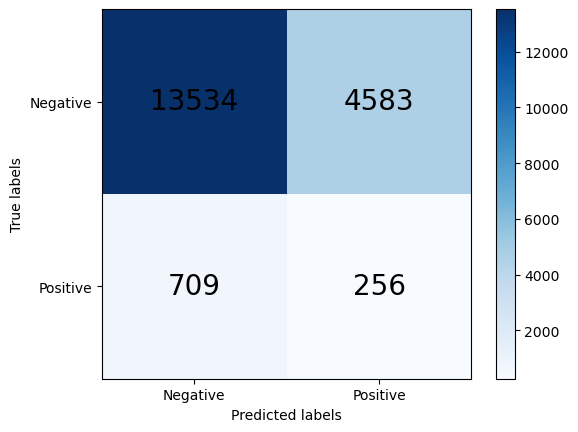

====== numericals_variance ======
Accuracy: 0.89 (+/- 0.01)
accuracy: 0.8158998008594487
precision:  0.05609756097560976
recall:  0.16683937823834197
f1:  0.08396349413298566


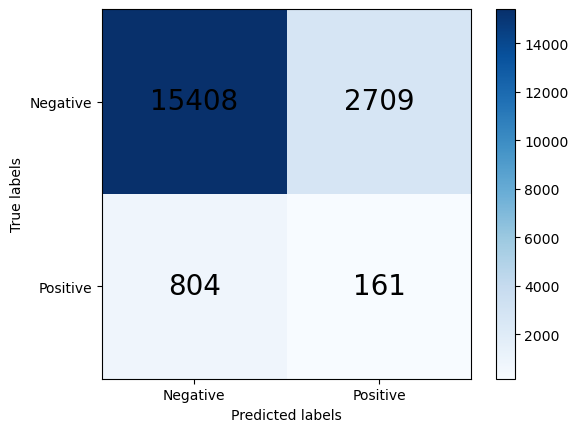

====== numericals_variance_manual_drop ======
Accuracy: 0.89 (+/- 0.01)
accuracy: 0.79792474583377
precision:  0.05509387503847338
recall:  0.18549222797927462
f1:  0.08495491219743712


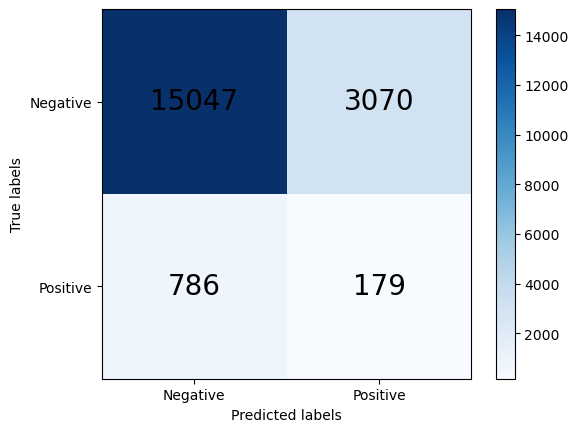

====== numericals_chi2 ======
Accuracy: 0.89 (+/- 0.00)
accuracy: 0.825280368934074
precision:  0.060808305524657026
recall:  0.1699481865284974
f1:  0.08956854178044785


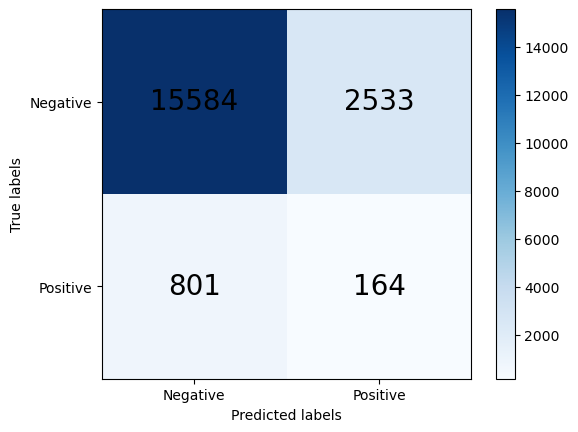

====== numericals_rfe ======
Accuracy: 0.89 (+/- 0.01)
accuracy: 0.8205638821926423
precision:  0.060421880586342507
recall:  0.17512953367875647
f1:  0.08984582668793194


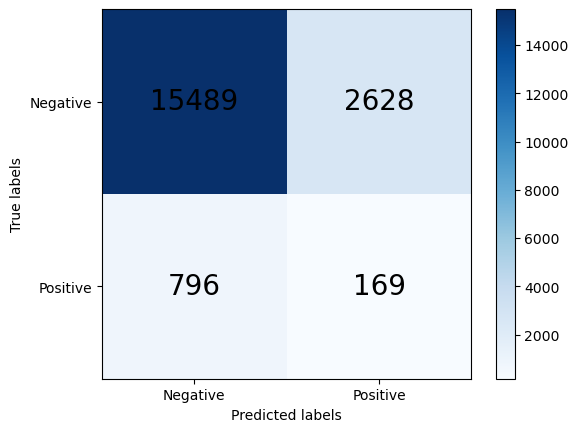

====== numericals_rfe_manual_drop ======
Accuracy: 0.89 (+/- 0.00)
accuracy: 0.8274813960800754
precision:  0.06077765194412986
recall:  0.16683937823834197
f1:  0.08909795240730493


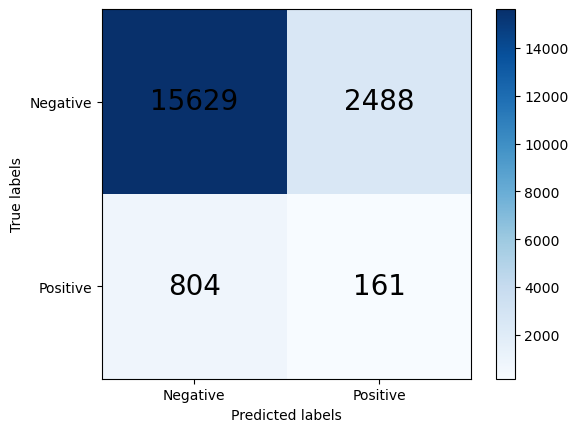

====== numericals_ols ======
Accuracy: 0.89 (+/- 0.00)
accuracy: 0.8349753694581281
precision:  0.06038647342995169
recall:  0.15544041450777202
f1:  0.08698173383589446


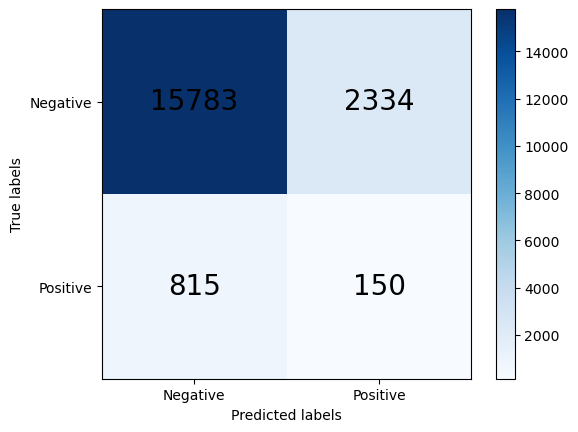

In [17]:
score_selected_columns(selectors=selectors)

#### `With Undersampling`

====== numericals ======
Accuracy: 0.53 (+/- 0.03)
accuracy: 0.5483177863955561
precision:  0.07991218441273326
recall:  0.7544041450777202
f1:  0.14451612903225808


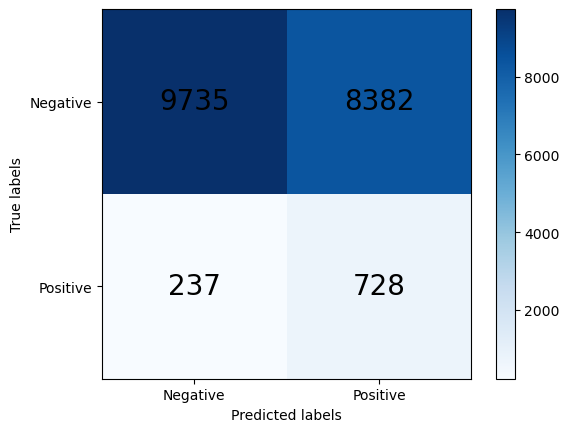

====== numericals_variance ======
Accuracy: 0.52 (+/- 0.04)
accuracy: 0.5581700031443245
precision:  0.10049229452054795
recall:  0.9730569948186528
f1:  0.1821709186148026


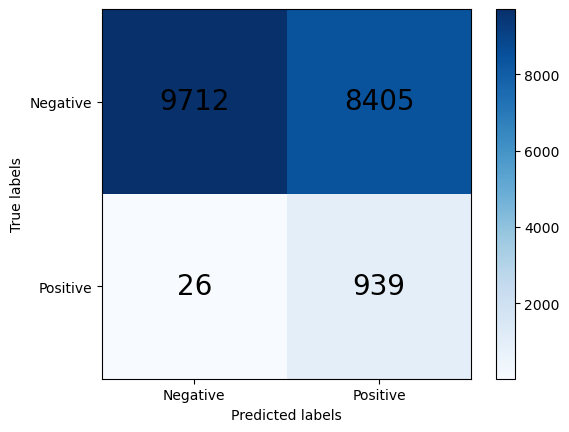

====== numericals_variance_manual_drop ======
Accuracy: 0.53 (+/- 0.03)
accuracy: 0.5628864898857562
precision:  0.1
recall:  0.9554404145077721
f1:  0.18105056455571922


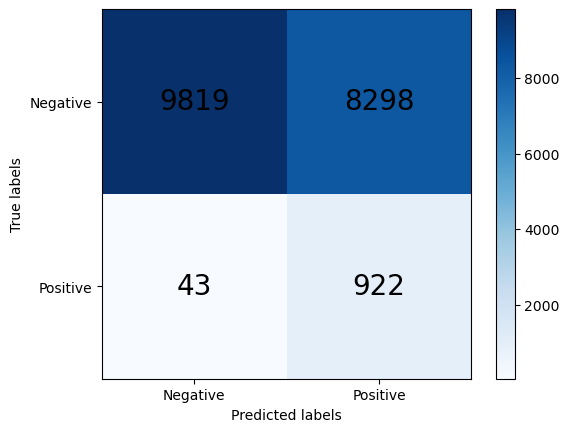

====== numericals_chi2 ======
Accuracy: 0.51 (+/- 0.03)
accuracy: 0.5565978408971806
precision:  0.1
recall:  0.9709844559585492
f1:  0.18132559264634737


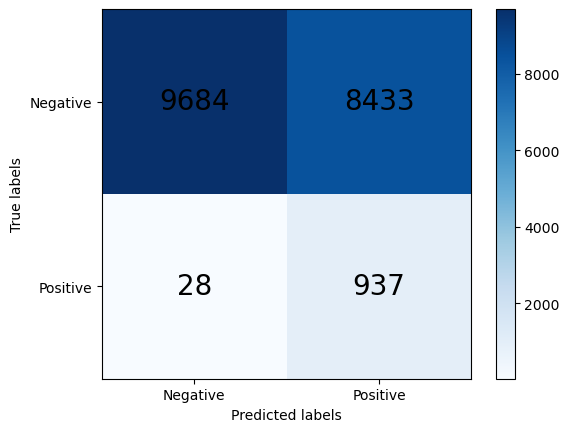

====== numericals_rfe ======
Accuracy: 0.52 (+/- 0.03)
accuracy: 0.5039828110260979
precision:  0.07694604817837945
recall:  0.8010362694300518
f1:  0.14040504949595858


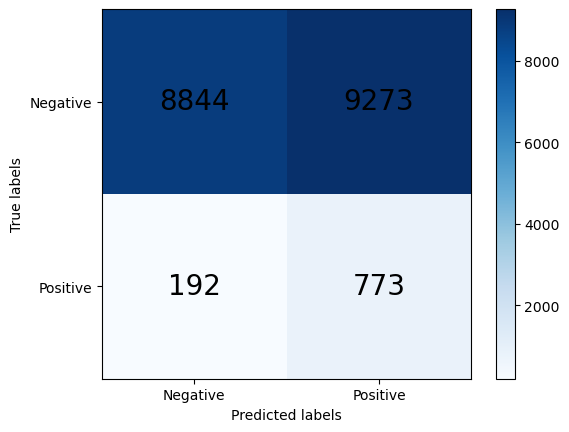

====== numericals_rfe_manual_drop ======
Accuracy: 0.51 (+/- 0.03)
accuracy: 0.49523110785033014
precision:  0.059110794587445316
recall:  0.6020725388601036
f1:  0.10765239948119325


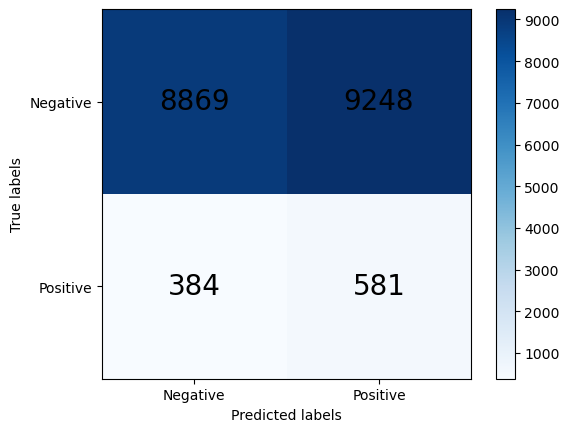

====== numericals_ols ======
Accuracy: 0.52 (+/- 0.03)
accuracy: 0.4707053767948852
precision:  0.06421143020704131
recall:  0.6974093264248704
f1:  0.11759566660842215


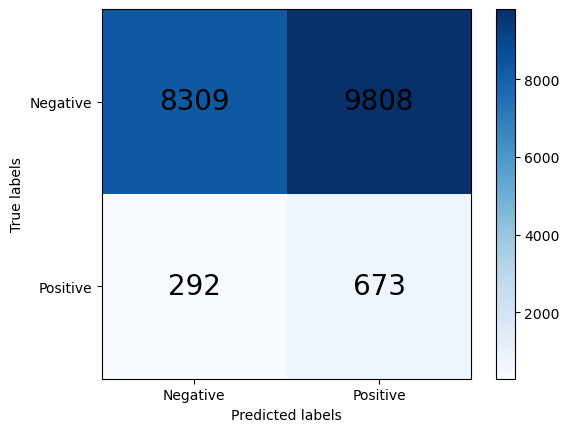

In [18]:
score_selected_columns(selectors=selectors, sample_action='undersample')

#### `With Oversampling`

====== numericals ======
Accuracy: 0.97 (+/- 0.00)
accuracy: 0.9248506445865213
precision:  0.2564901349948079
recall:  0.2559585492227979
f1:  0.2562240663900415


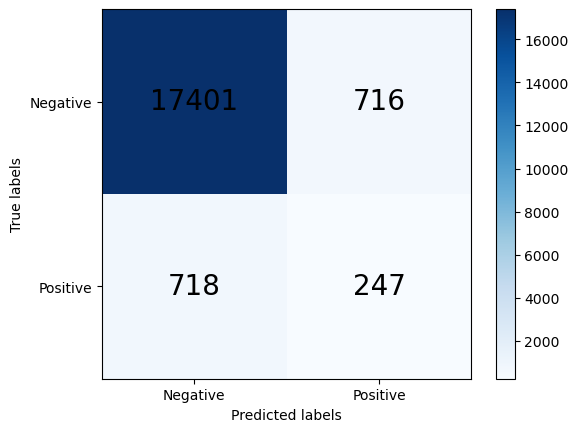

====== numericals_variance ======
Accuracy: 0.97 (+/- 0.00)
accuracy: 0.9669321874017398
precision:  0.6728778467908902
recall:  0.6735751295336787
f1:  0.6732263076126359


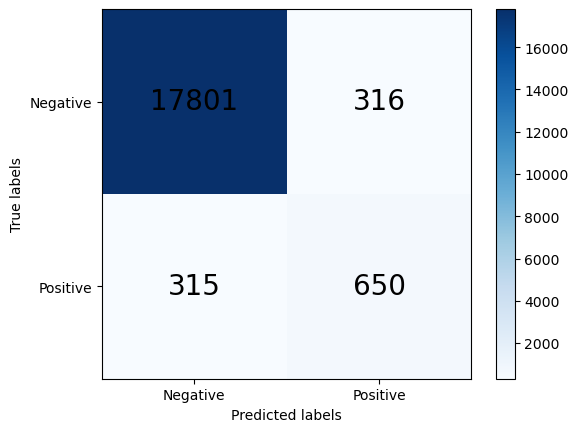

====== numericals_variance_manual_drop ======
Accuracy: 0.97 (+/- 0.00)
accuracy: 0.9756838905775076
precision:  0.7595854922279792
recall:  0.7595854922279792
f1:  0.7595854922279792


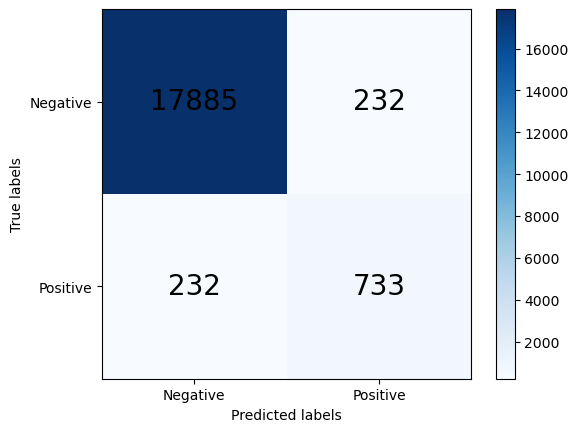

====== numericals_chi2 ======
Accuracy: 0.97 (+/- 0.00)
accuracy: 0.9780945393564616
precision:  0.8022099447513812
recall:  0.7523316062176166
f1:  0.776470588235294


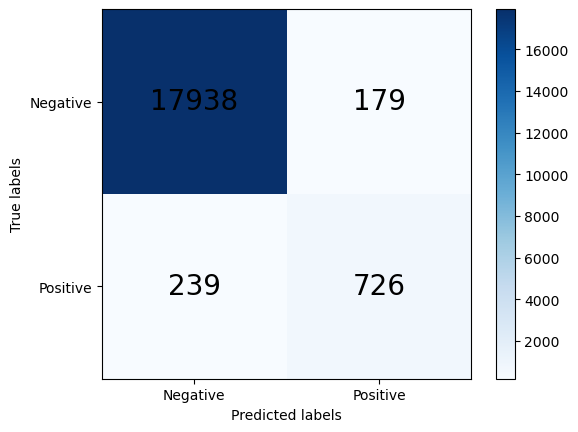

====== numericals_rfe ======
Accuracy: 0.97 (+/- 0.00)
accuracy: 0.9390525102190546
precision:  0.35311572700296734
recall:  0.24663212435233162
f1:  0.2904209884075656


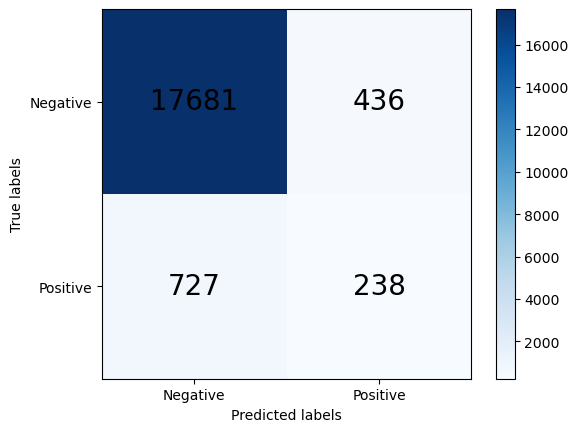

====== numericals_rfe_manual_drop ======
Accuracy: 0.97 (+/- 0.00)
accuracy: 0.9352269154176711
precision:  0.31713900134952766
recall:  0.24352331606217617
f1:  0.2754982415005862


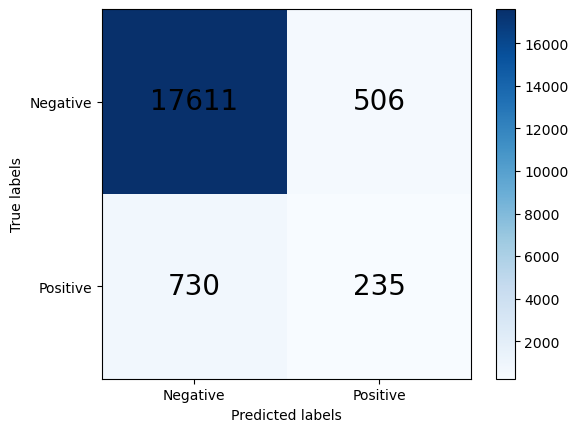

====== numericals_ols ======
Accuracy: 0.97 (+/- 0.00)
accuracy: 0.9450791321664396
precision:  0.4485749690210657
recall:  0.37512953367875645
f1:  0.40857787810383744


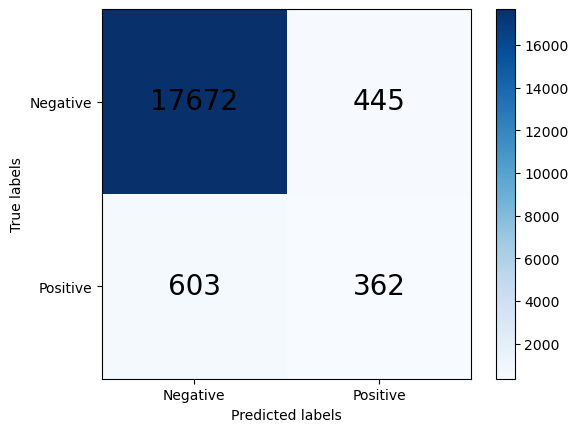

In [19]:
score_selected_columns(selectors=selectors, sample_action='oversample')

#### `Comments`

In [20]:
# Columns selected in 'numericals_chi2' with Oversampled 'TARGET_B' seems to give us better results.
# Metrics show less false positive and overall better performance.